<!--BOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="figures/kep.png" height=75 width=75>
*This notebook uses routines from [PyKE](http://github.com/keplerGO/PyKE/) which is documented [here](http://pyke.keplerscience.org/). You can find these notebooks on [GitHub](https://github.com/christinahedges/k2torials)*

<!--NAVIGATION-->
< [Folding a Light Curve](01.03-Folding-A-Lightcurve.ipynb) | [Contents](http://nbviewer.jupyter.org/github/christinahedges/k2torials/tree/master/notebooks/index.ipynb) | [Which Flux to Use](01.13-Which-FLUX-to-use.ipynb) >

# Fitting a Basic Transit Model

Now we have a folded light curve we can fit a transit model to it. There are several packages to do this, based on several models implementations. I will go through a basic example of how to 1) create a transit model using existing packages 2) fit that transit model with scipy. 

Transit model implementations:
* BATMAN
* PyTransit
* KTransit




Let's load the data that we're working with again. In the last notebook we already folded and found the period of the planet.

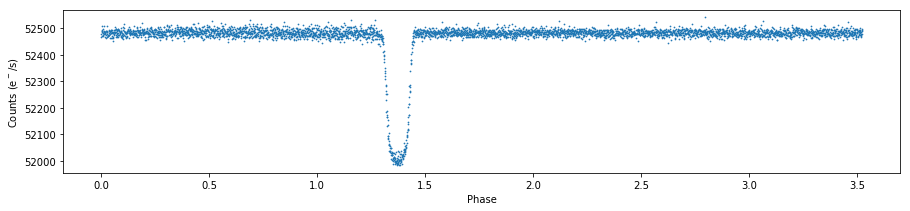

In [618]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
h = fits.open('data/kplr006922244-2010078095331_llc.fits')
h[1].data.names
t,flux,err=h[1].data['TIME'],h[1].data['PDCSAP_FLUX'],h[1].data['PDCSAP_FLUX_ERR']
t,flux,err=t[np.isfinite(flux)],flux[np.isfinite(flux)],err[np.isfinite(err)]





per=3.52233911024
phase = t  % per

plt.figure(figsize=(15,3))
plt.scatter(phase,flux,s=0.5)
plt.xlabel('Phase')
plt.ylabel('Counts (e$^-$/s)')


### Limb Darkening

In the transit above the curved edges are due to limb darkening. The edges or limbs of the star are darker than the center, causing the transit depth to be shallower at *ingress* and *egress* (the slopes into and out of the transit.) You can read more about limb darkening and its effects [here](limbdarkening).

The effect of limb darkening is different depending on the star parameters and the bandpass that you observe in. We can use the package [*LDTK*](https://github.com/hpparvi/ldtk) to calculate the limb darkening parameters for our star.

Using the metadata in the header file (also discussed in previous notebooks) we can load in information about the host star. This information is based on the Kepler Input Catalog (KIC) and gives an approximation of the temperature, surface gravity and metallicity.

In [593]:
teff = h[0].header['TEFF']
logg = h[0].header['LOGG']
feh = h[0].header['FEH']
r= h[0].header['RADIUS']*u.solRad


g=((10.**logg)*u.cm/(u.second**2))
m=((g*r**2/G).to(u.kg)).to(u.solMass)

print('Star Parameters')
print('----------------')
print('Mass: {:0.3}'.format(m))
print('Radius: {:0.3}'.format(r))
print('T_eff: {}'.format(teff*u.K))
print('logg: {:0.3}'.format(logg))
print('FeH: {:0.3}'.format(feh))

Star Parameters
----------------
Mass: 1.13 solMass
Radius: 1.45 solRad
T_eff: 6225.0 K
logg: 4.17
FeH: -0.04


Using *LDTK* we can calculate the limb darkening coefficients based on these stellar parameters. *ldtk* comes with the *Kepler* bandpass preloaded. 

*LDTK* will download stellar spectra from an online repository in a grid around our $T_{eff}$, $log(g)$ and FeH parameters. In this case we have chosen points that are within 50K, 0.1 dex in logg and 0.05 dex in FeH. This is $\approx$40 files and is around $500Mb$ of data. If you don't have the time to run this yourself the code finds the following limb darkening parameters:

$u=0.5230\pm0.0010\;\;$
$v=0.1218\pm0.0015$
 

In [594]:
from ldtk import LDPSetCreator, BoxcarFilter, TabulatedFilter
from ldtk.filters import kepler
from IPython.display import display, Latex
sc = LDPSetCreator(teff=(teff,50), logg=(logg,0.1), z=(feh,0.05), filters=[kepler])
ps = sc.create_profiles()

qc,qe = ps.coeffs_qd()
for i,(c,e) in enumerate(zip(qc,qe)):
    display(Latex('u$_{i:d} = {c[0]:5.4f} \pm {e[0]:5.4f}\quad$'
                  'v$_{i:d} = {c[1]:5.4f} \pm {e[1]:5.4f}$'.format(i=i+1,c=c,e=e)))


<IPython.core.display.Latex object>

Now that we have limb darkening parameters we can build a transit model. In this case we're going to use [BATMAN](https://astro.uchicago.edu/~kreidberg/batman/installation.html). This package is fairly easy to install and use and employs a Mandol and Agol (2002) model for transits. You can read more about transit models [here](transitmodels).

Firstly we will initialise our transit model. For this simple example we are going to assume that the planet is on a circular orbit with an inclination of 0. This is for the simplicity of fitting in this example.

In [742]:
import batman
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
params = batman.TransitParams()       #object to store transit parameters
params.ecc = 0.                       #eccentricity
params.w = 90.                        #longitude of periastron (in degrees)
params.limb_dark = "quadratic"        #limb darkening model
params.u = [0.5230, 0.1218]           #limb darkening coefficients
params.per = per                      #orbital period

We have fixed the period and the transit midpoint to the values we have already found in previous notebooks. We do not really need to fit these parameters.

In [751]:
rp_init=((np.median(flux)-np.min(flux))/np.median(flux))**0.5
i_init=90

t0_init=1.30
d=(((per*u.day).to(u.second))**2*G*m/(4*pi**2))**(1./3.)
a_init=(d.to(u.solRad)/r).value

In [757]:
def func(guess,return_model=False):
    params.rp=guess[0]
    params.a=guess[1]
    params.inc=guess[2]
    params.t0=guess[3]
    m = batman.TransitModel(params, np.sort(phase))
    model=m.light_curve(params)*np.median(flux)
    
    if return_model:
        return(model)
    else:
        return((np.nansum((flux[np.argsort(phase)]-model)**2/flux[np.argsort(phase)])))

In [758]:
from scipy.optimize import minimize
res=minimize(func,[rp_init,a_init,i_init,t0_init],method='Powell')

In [759]:

labels=['$R_p/R_*$','a/$R_*$','Inclination','MidPoint']
display(Latex('Initial Guess:'))
for l,i in zip(labels,[rp_init,a_init,i_init,t0_init]):
    display(Latex('{}:$\;${:0.4}'.format(l,float(i))))
print()
display(Latex('Best Fit:'))
for l,i in zip(labels,res.x):
    display(Latex('{}:$\;${:0.4}'.format(l,float(i))))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [760]:

lcm = func([rp_init,a_init,i_init,t0_init],return_model=True)
lcm_fit = func(res.x,return_model=True)


(1.18, 1.57)

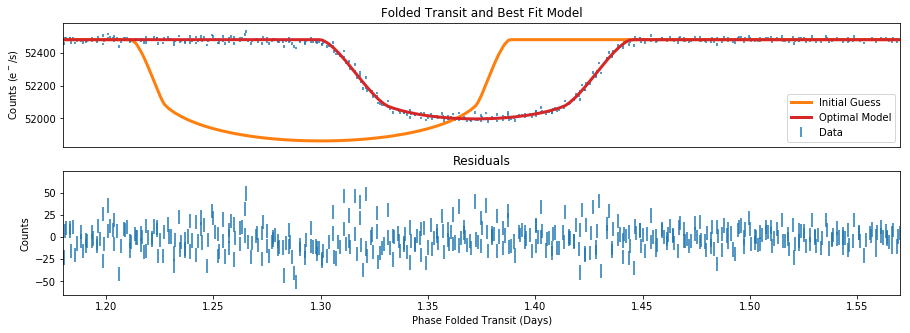

In [761]:
fig,ax=plt.subplots(2,figsize=(15,5))
ax[0].errorbar(phase,flux,err,ls='',label='Data')
ax[0].set_ylabel('Counts (e$^-$/s)')
ax[0].plot(np.sort(phase),lcm,c='C1',label='Initial Guess',lw=3)
ax[0].plot(np.sort(phase),lcm_fit,c='C3',label='Optimal Model',lw=3)
ax[0].legend()
ax[0].set_xticks([])
ax[0].set_title('Folded Transit and Best Fit Model')

ax[1].errorbar(np.sort(phase),flux[np.argsort(phase)]-lcm_fit,err,ls='',label='Data')
ax[1].set_xlabel('Phase Folded Transit (Days)')
ax[1].set_ylabel('Counts')
ax[1].set_title('Residuals')

ax[0].set_xlim(1.18,1.57)
ax[1].set_xlim(1.18,1.57)



#plt.axhline(np.min(flux))
#plt.axhline(np.median(flux))

(0.999, 1.001)

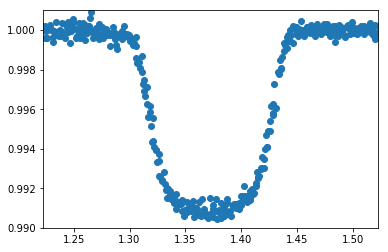

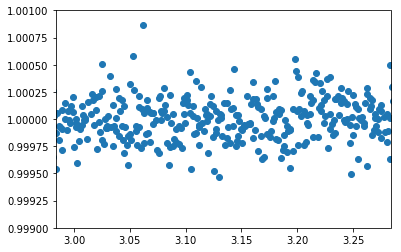

In [775]:
plt.scatter(phase,flux/np.median(flux))
plt.xlim(res.x[3]-0.15,res.x[3]+0.15)
plt.ylim(0.99,1.001)
plt.figure()
plt.scatter(phase,flux/np.median(flux))
plt.xlim(res.x[3]-0.15+per*0.5,res.x[3]+0.15+per*0.5)
plt.ylim(0.999,1.001)

<!--NAVIGATION-->
< [Folding a Light Curve](01.03-Folding-A-Lightcurve.ipynb) | [Contents](http://nbviewer.jupyter.org/github/christinahedges/k2torials/tree/master/notebooks/index.ipynb) | [Which Flux to Use](01.13-Which-FLUX-to-use.ipynb) >